In [23]:
library(readr)
library(dplyr)
library(stringr)
library(lubridate)

In [25]:
loan <- read_csv('loan.csv', col_types = cols())
glimpse(loan)

Observations: 39,717
Variables: 111
$ id                             <int> 1077501, 1077430, 1077175, 1076863, ...
$ member_id                      <int> 1296599, 1314167, 1313524, 1277178, ...
$ loan_amnt                      <int> 5000, 2500, 2400, 10000, 3000, 5000,...
$ funded_amnt                    <int> 5000, 2500, 2400, 10000, 3000, 5000,...
$ funded_amnt_inv                <dbl> 4975.00, 2500.00, 2400.00, 10000.00,...
$ term                           <chr> "36 months", "60 months", "36 months...
$ int_rate                       <chr> "10.65%", "15.27%", "15.96%", "13.49...
$ installment                    <dbl> 162.87, 59.83, 84.33, 339.31, 67.79,...
$ grade                          <chr> "B", "C", "C", "C", "B", "A", "C", "...
$ sub_grade                      <chr> "B2", "C4", "C5", "C1", "B5", "A4", ...
$ emp_title                      <chr> NA, "Ryder", NA, "AIR RESOURCES BOAR...
$ emp_length                     <chr> "10+ years", "< 1 year", "10+ years"...
$ home_ownership

In [26]:
# large number of columns are complete NAs
colSums(sapply(loan, FUN = function(c) is.na(c)))

id                      member_id 
                             0                              0 
                     loan_amnt                    funded_amnt 
                             0                              0 
               funded_amnt_inv                           term 
                             0                              0 
                      int_rate                    installment 
                             0                              0 
                         grade                      sub_grade 
                             0                              0 
                     emp_title                     emp_length 
                          2453                              0 
                home_ownership                     annual_inc 
                             0                              0 
           verification_status                        issue_d 
                             0                              0 
                   loan_status                     pymnt_plan 
                             0                              0 
                           url                           desc 
                             0                          13149 
                       purpose                          title 
                             0                             10 
                      zip_code                     addr_state 
                             0                              0 
                           dti                    delinq_2yrs 
                             0                              0 
              earliest_cr_line                 inq_last_6mths 
                             0                              0 
        mths_since_last_delinq         mths_since_last_record 
                         25682                          36931 
                      open_acc                        pub_rec 
                             0                              0 
                     revol_bal                     revol_util 
                             0                             50 
                     total_acc            initial_list_status 
                             0                              0 
                     out_prncp                  out_prncp_inv 
                             0                              0 
                   total_pymnt                total_pymnt_inv 
                             0                              0 
               total_rec_prncp                  total_rec_int 
                             0                              0 
            total_rec_late_fee                     recoveries 
                             0                              0 
       collection_recovery_fee                   last_pymnt_d 
                             0                             71 
               last_pymnt_amnt                   next_pymnt_d 
                             0                          38577 
            last_credit_pull_d     collections_12_mths_ex_med 
                             2                             56 
   mths_since_last_major_derog                    policy_code 
                         39717                              0 
              application_type               annual_inc_joint 
                             0                          39717 
                     dti_joint      verification_status_joint 
                         39717                          39717 
                acc_now_delinq                   tot_coll_amt 
                             0                          39717 
                   tot_cur_bal                    open_acc_6m 
                         39717                          39717 
                    open_il_6m                    open_il_12m 
                         39717                          39717 
                   open_il_24m             mths_since_rcnt_il 
                         39717                          397

In [27]:
# removing columns with full NAs
loan <- loan %>% select_if(function(c) !all(is.na(c)))

# removing columns with 0's
loan <- loan %>% select_if(function(c) !all(c == 0, na.rm = T))

# removing variables that dont contribute to analysis
loan[, c('pymnt_plan', 'url', 'desc', 'initial_list_status', 
         'application_type', 'emp_title', 'title', 'policy_code')] <- NULL

In [28]:
# data type conversions

loan$int_rate <- str_remove(loan$int_rate, '%') %>% as.numeric()
loan$revol_util <- str_remove(loan$revol_util, '%') %>% as.numeric()

loan$issue_d <- parse_date_time(loan$issue_d, orders = 'my')
loan$earliest_cr_line <- parse_date_time(loan$earliest_cr_line, orders = 'my')
loan$last_pymnt_d <- parse_date_time(loan$last_pymnt_d, orders = 'my')
loan$next_pymnt_d <- parse_date_time(loan$next_pymnt_d, orders = 'my')
loan$last_credit_pull_d <- parse_date_time(loan$last_credit_pull_d, orders = 'my')

# factor variables
fact_var <- c('id', 'member_id', 'term', 'grade', 'sub_grade', 'emp_length', 'home_ownership', 
              'verification_status', 'loan_status', 'purpose', 'inq_last_6mths')

loan[,fact_var] <- lapply(loan[,fact_var], FUN = function(c) as.factor(c))

### consumer attributes affecting the tendency of default

In [51]:
options(repr.plot.width=4, repr.plot.height=3)

Warning message:
"Removed 7861 rows containing non-finite values (stat_boxplot)."

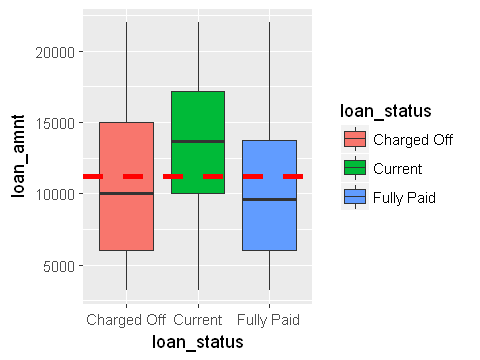

In [30]:
# mean loan_amt of charged off ppl is higher than that of fully paid
ggplot(loan, aes(x = loan_status, y = loan_amnt, fill = loan_status)) + geom_boxplot(outlier.shape = NA) +
  scale_y_continuous(limits = quantile(loan$loan_amnt, c(0.1, 0.9))) + 
  geom_hline(yintercept = mean(loan$loan_amnt), col = 'red', lwd = 1.5, linetype = 'dashed')

In [50]:
# younger and senior ppl are more likely to default on loan
loan %>% filter(loan_status == 'Charged Off') %>%  group_by(emp_length) %>% count() %>% arrange(desc(n)) %>% head()

emp_length,n
10+ years,1331
< 1 year,639
2 years,567
3 years,555
4 years,462
5 years,458


Warning message:
"Removed 7861 rows containing non-finite values (stat_boxplot)."

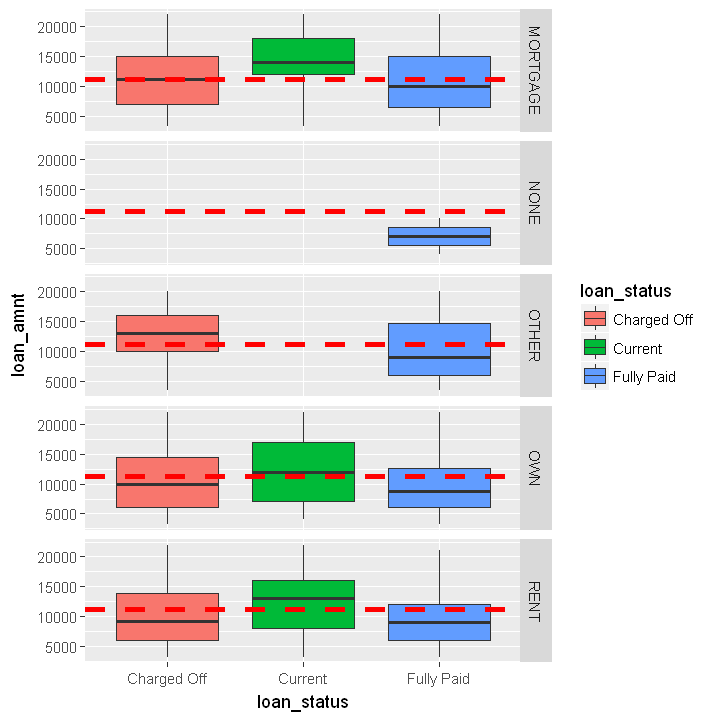

In [36]:
# the amount of money ppl default is higher for 'other' loan_status type
ggplot(loan, aes(x = loan_status, y = loan_amnt, fill = loan_status)) + geom_boxplot(outlier.shape = NA) +
  scale_y_continuous(limits = quantile(loan$loan_amnt, c(0.1, 0.9))) + 
  geom_hline(yintercept = mean(loan$loan_amnt), col = 'red', lwd = 1.5, linetype = 'dashed') +
  facet_grid(home_ownership ~ .)

Warning message:
"Removed 7745 rows containing non-finite values (stat_boxplot)."

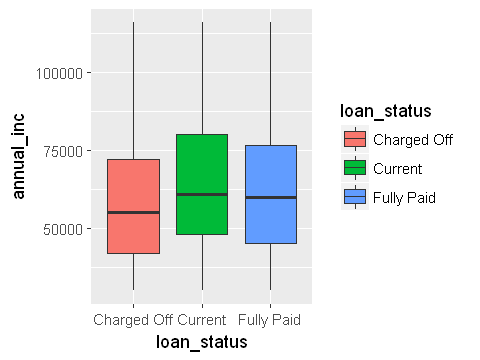

In [52]:
# a very strong indication for ppl who default is lower annual incomes
ggplot(loan, aes(x = loan_status, y = annual_inc, fill = loan_status)) + geom_boxplot(outlier.shape = NA) +
  scale_y_continuous(limits = quantile(loan$annual_inc, c(0.1, 0.9)))

In [49]:
# ppl who take laon for debt_consolidation are very much likely to default
loan %>% filter(loan_status == 'Charged Off') %>%  group_by(purpose) %>% count() %>% arrange(desc(n)) %>% head()

purpose,n
debt_consolidation,2767
other,633
credit_card,542
small_business,475
home_improvement,347
major_purchase,222


In [47]:

# top 15 zipcodes and states where ppl usually default
loan %>% filter(loan_status == 'Charged Off') %>%  group_by(zip_code) %>% 
  count() %>% arrange(desc(n)) %>% head(n = 5)

zip_code,n
945xx,80
917xx,71
100xx,70
331xx,70
926xx,67


In [48]:
# californians are more likely to default on their loans
loan %>% filter(loan_status == 'Charged Off') %>%  group_by(addr_state) %>% 
  count() %>% arrange(desc(n)) %>% head(n = 5)

addr_state,n
CA,1125
FL,504
NY,495
TX,316
NJ,278


In [41]:
# ppl with more than 30 open credit lines are more likely to default
loan %>%  select(loan_status, open_acc) %>% group_by(loan_status) %>% 
  top_n(3, wt = open_acc) %>% arrange(loan_status, desc(open_acc)) %>% print(n = Inf)

# A tibble: 10 x 2
# Groups:   loan_status [3]
   loan_status open_acc
   <fct>          <int>
 1 Charged Off       38
 2 Charged Off       35
 3 Charged Off       34
 4 Current           32
 5 Current           28
 6 Current           25
 7 Current           25
 8 Fully Paid        44
 9 Fully Paid        42
10 Fully Paid        41


In [42]:
loan$earliest_cr_line_yr <- year(loan$earliest_cr_line)
# fix bcz lubridate converts numbers < 68 to < 2068 instead of < 1968
loan[which(loan$earliest_cr_line_yr > 2018), 'earliest_cr_line_yr'] <- 
  loan[which(loan$earliest_cr_line_yr > 2018), 'earliest_cr_line_yr'] - 100

In [43]:
loan_default <- loan %>% filter(loan_status == 'Charged Off')

In [45]:
# ppl with earliest credit line in 2000, 1999, 1998 are likely to default
loan_default %>% group_by(earliest_cr_line_yr) %>% count() %>% arrange(desc(n)) %>% head()

earliest_cr_line_yr,n
2000,500
1999,442
1998,415
1997,374
2001,356
1995,303


Warning message:
"Removed 7943 rows containing non-finite values (stat_boxplot)."

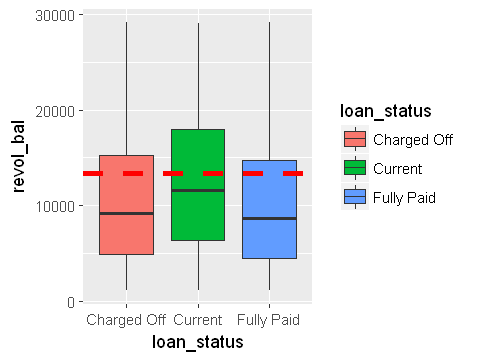

In [53]:
# loan status vs revol bal
ggplot(loan, aes(x = loan_status, y = revol_bal, fill = loan_status))+ geom_boxplot(outlier.shape = NA) +
  scale_y_continuous(limits = quantile(loan$revol_bal, c(0.1, 0.9))) +
  geom_hline(yintercept = mean(loan$revol_bal, na.rm = T), col = 'red', lwd = 1.5, linetype = 'dashed')

Warning message:
"Removed 50 rows containing non-finite values (stat_boxplot)."

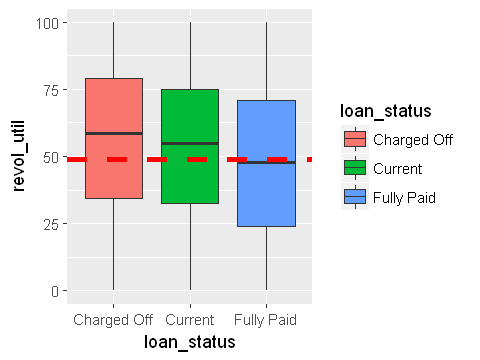

In [54]:
# ppl who default tend to utilise majority of their revol bal
ggplot(loan, aes(x = loan_status, y = revol_util, fill = loan_status)) + geom_boxplot() +
  geom_hline(yintercept = mean(loan$revol_util, na.rm = T), col = 'red', lwd = 1.5, linetype = 'dashed')

### loan attributes

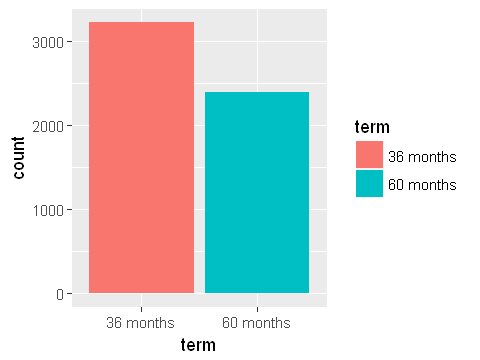

In [55]:
# contrary to our belief, ppl with low terms are likely to default
ggplot(loan_default, aes(x = term, fill = term)) + geom_bar() 

In [56]:
# interes rate for defaulters is higher
loan %>% group_by(loan_status) %>% summarise(avg_int = mean(int_rate))

loan_status,avg_int
Charged Off,13.82043
Current,15.03146
Fully Paid,11.60976


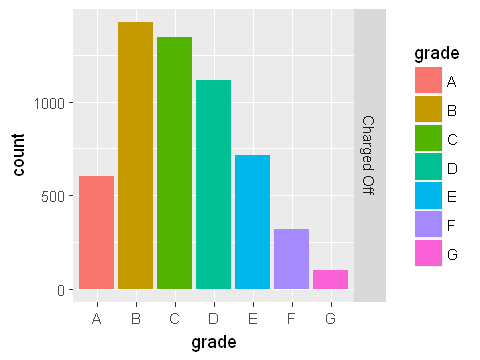

In [58]:
# ppl with B, C, D grades are likey to default
loan_default %>% ggplot(aes(x = grade, fill = grade)) + geom_bar() + facet_grid(loan_status ~ .)

In [59]:
# majority of defaulters source has not been verified
loan_default %>% group_by(verification_status) %>% count()

verification_status,n
Not Verified,2142
Source Verified,1434
Verified,2051


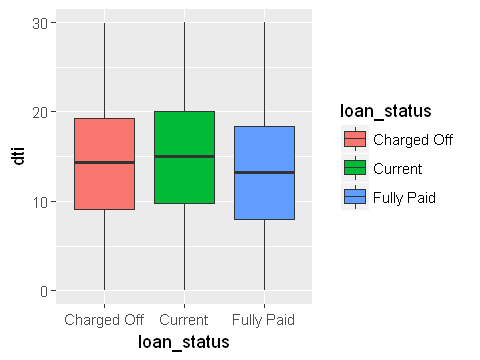

In [60]:
# lesser dti is preferable but defaulters have higher dti vs non-defaulters
loan %>% ggplot(aes(x = loan_status, y = dti, fill = loan_status)) + geom_boxplot()